# Image representation
The code expects the script siren.py to be under '/content/drive/MyDrive/Colab Notebooks ' (or at the same folder if run locally) and the images to be under '/content/drive/MyDrive/Colab Notebooks/data/48/' (or under ./data/48 if run locally)
The network is built such that it expects image coordinates and image index as input and gives the pixel value in the form of RGBA in that coordinate for the image index output.

Imports drive mount and cuda

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os
import sys

from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread_collection, imread
from google.colab import drive
drive.mount('/content/drive')
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks')
import siren
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

Mounted at /content/drive


Get all images and calcualte mean and

In [2]:
img_dir = '/content/drive/MyDrive/Colab Notebooks/data/48/*.png'
images = imread_collection(img_dir)
imagesData = np.stack([img for img in images])
mean = np.mean(imagesData, axis=(0, 1, 2)) / 255
std = np.std(imagesData, axis=(0, 1, 2)) / 255

Build Dataloader - returns the input (for each co-ordinate an additional idx value) and the image itself
Build and train Siren network with co-ordinates+idx as input

In [3]:
input = siren.ImageFittingIdx(imagesData, mean, std, 48)
dataloader = DataLoader(input, batch_size=100, pin_memory=True, num_workers=0)

img_siren = siren.Siren(in_features=3, out_features=4, hidden_features=512, 
                  hidden_layers=4, outermost_linear=True)
img_siren.to(device)
train_losses = siren.train(img_siren, dataloader, 500, device)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step 0, Total loss 1.003168
Step 100, Total loss 0.032395
Step 200, Total loss 0.005568
Step 300, Total loss 0.002176
Step 400, Total loss 0.001254


Save the model

In [4]:
from google.colab import files
torch.save(img_siren.state_dict(), '/content/drive/MyDrive/Colab Notebooks/img_siren_A.pt')
files.download('/content/drive/MyDrive/Colab Notebooks/img_siren_A.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Test the network, presnet every image the network learned by it's index

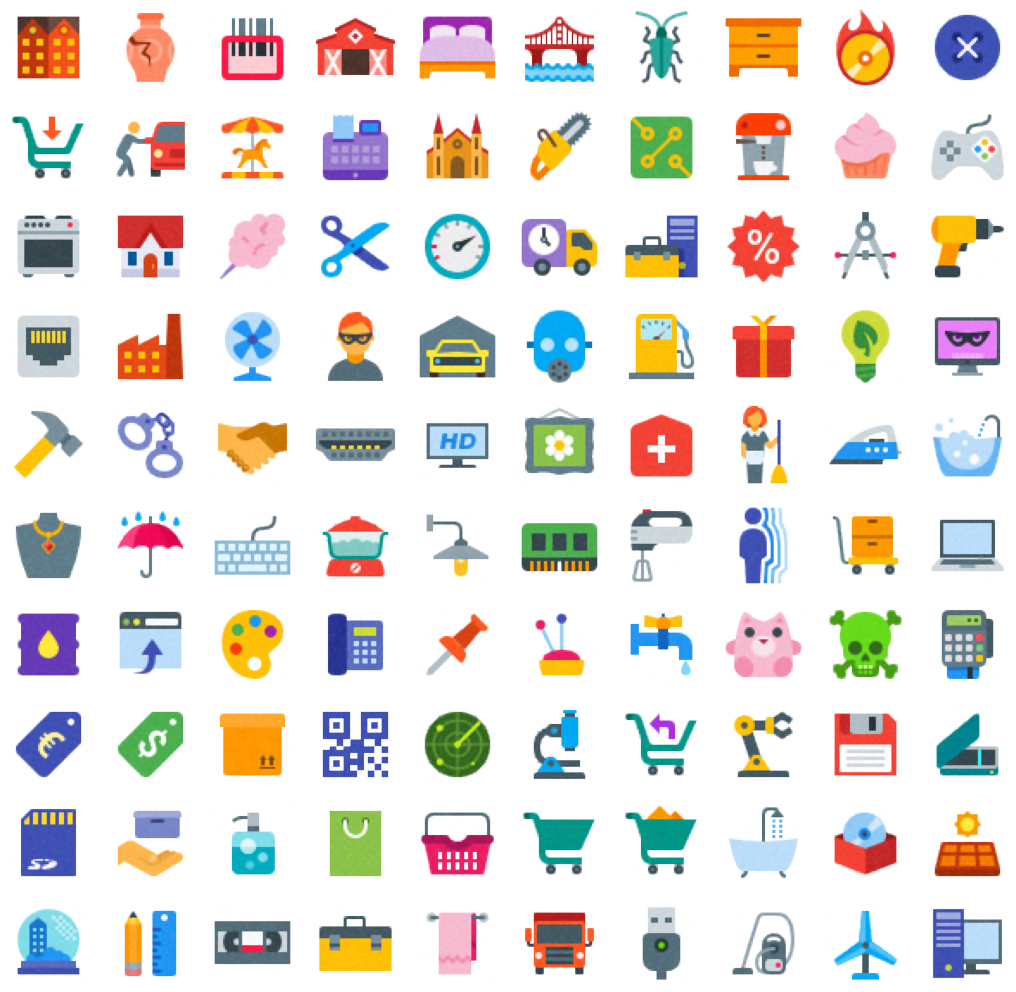

In [5]:
fig, axes = plt.subplots(10,10, figsize=(18,18))
for i in range(10):
    for j in range(10):
        normalized_img = img_siren(torch.cat([siren.get_mgrid(48, 2), torch.full((2304, 1), i*10+j)], dim=1).to(device))[0].view(48, 48, 4).cpu().detach().numpy()
        img = 255*(normalized_img * std + mean)
        img = np.clip(img, 0,255).astype(np.int32) 
        axes[i,j].imshow(img)
        axes[i,j].axis('off')
plt.show()

# New images - Upsample
reload the model from file
for 3 random images upsample to 256x256 by entering the co-ordinates of the upsamples image

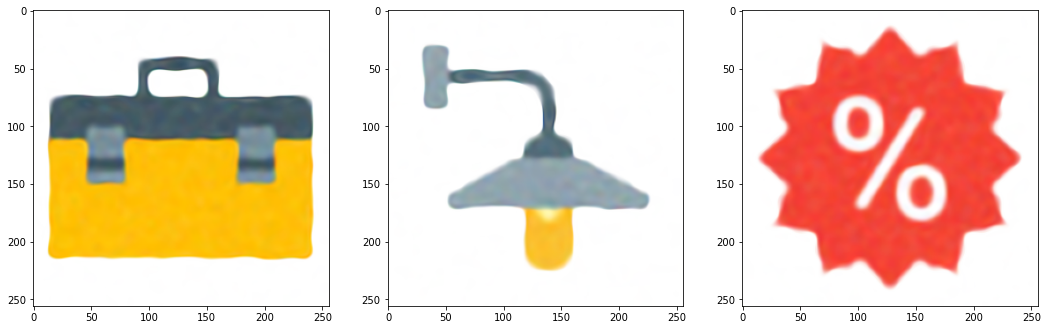

In [6]:
img_siren = siren.Siren(in_features=3, out_features=4, hidden_features=512, hidden_layers=4, outermost_linear=True)
img_siren.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/img_siren_A.pt', map_location=device))
fig, axes = plt.subplots(1,3, figsize=(18,18))
j = np.random.randint(0,100,3)
for i in range(3):
    normalized_img = img_siren(torch.cat([siren.get_mgrid(256, 2), torch.full((65536, 1), j[i])], dim=1))[0].view(256, 256, 4).detach().numpy()
    img = np.clip(255*(normalized_img * std + mean), 0,255).astype(np.int32)
    axes[i].imshow(img)
plt.show()

As he results are not with the highest quality i decided to tarin a network for a single image, and show upsample with this network

In [3]:
imagesData = imread('/content/drive/MyDrive/Colab Notebooks/data/48/radar-48.png')
mean = np.mean(imagesData, axis=(0, 1)) / 255
std = np.std(imagesData, axis=(0, 1)) / 255

In [4]:
input = siren.ImageFitting(imagesData, mean, std, 256)
dataloader = DataLoader(input, batch_size=1, pin_memory=True, num_workers=0)

img_siren = siren.Siren(in_features=2, out_features=4, hidden_features=256, 
                  hidden_layers=3, outermost_linear=True)
img_siren.to(device)
train_losses = siren.train(img_siren, dataloader, 500, device)

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step 0, Total loss 1.949434
Step 100, Total loss 0.038709
Step 200, Total loss 0.007387
Step 300, Total loss 0.005077
Step 400, Total loss 0.003903


In [9]:
from google.colab import files
torch.save(img_siren.state_dict(), '/content/drive/MyDrive/Colab Notebooks/img_siren_B.pt')
files.download('/content/drive/MyDrive/Colab Notebooks/img_siren_B.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

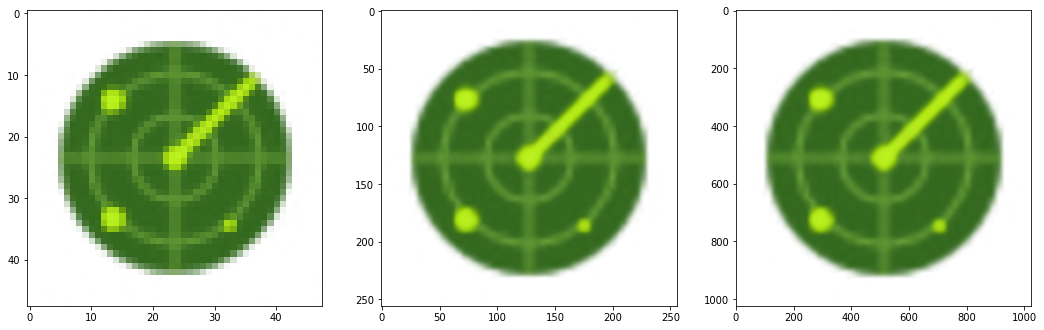

In [6]:
normalized_img = img_siren(siren.get_mgrid(48, 2).to(device))[0].view(48, 48, 4).cpu().detach().numpy()
img1 = np.clip(255*(normalized_img * std + mean), 0,255).astype(np.int32)
normalized_img = img_siren(siren.get_mgrid(256, 2).to(device))[0].view(256, 256, 4).cpu().detach().numpy()
img2 = np.clip(255*(normalized_img * std + mean), 0,255).astype(np.int32)
normalized_img = img_siren(siren.get_mgrid(1024, 2).to(device))[0].view(1024, 1024, 4).cpu().detach().numpy()
img3 = np.clip(255*(normalized_img * std + mean), 0,255).astype(np.int32)
fig, axes = plt.subplots(1,3, figsize=(18,18))
axes[0].imshow(img1)
axes[1].imshow(img2)
axes[2].imshow(img3)
plt.show()